## 1. Importer les bibliothèques

In [19]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

warnings.filterwarnings('ignore')

# Définir le style pour meilleures visualisations
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100

In [20]:
df = pd.read_csv('data/cleaned_chicken_market_study_data.csv', sep=',')
df.head()

,Country Name,Country Code,Total Population,Access to Electricity (%),Population Growth Rate,Urban Population Growth Rate,Urban Population,Political Stability Index,Regulatory Quality Index,Logistics Performance Index,GDP per Capita Growth (%),GDP per Capita (current US$),Chicken Meat Production (kg),Import Quantity (kg),Export Quantity (kg),Poultry Consumption (kg),Import Dependency Ratio,Self-Sufficiency Ratio,Poultry Consumption Growth Potential
0,Afghanistan,AFG,40578842.0,85.3,1.435704,2.576854,10800465.0,-2.544956,-1.271806,1.9,-7.576669,357.261153,2.850314e+07,6902310.0,56040.0,3.578203e+07,19.525955,80.632576,9.220507e+07
1,Angola,AGO,35635029.0,48.5,3.143026,4.059358,24260684.0,-0.630109,-0.606699,2.1,-0.143628,2929.694455,5.717738e+07,308122710.0,10870.0,3.743962e+08,84.350343,15.652633,1.519808e+09
2,United Arab Emirates,ARE,10074977.0,100.0,5.088342,5.367449,8819937.0,0.744183,1.034781,4.0,2.176083,49899.065298,4.700000e+07,615447940.0,94007430.0,5.131117e+08,108.269543,8.268235,2.754101e+09
3,Argentina,ARG,45407904.0,100.0,0.210809,0.338668,41932837.0,-0.098594,-0.697566,2.8,5.048195,13935.681111,2.319469e+09,10218320.0,179621830.0,2.193142e+09,0.475256,107.878993,7.427477e+08
4,Armenia,ARM,2969200.0,100.0,0.232656,0.456271,1887610.0,-0.740756,-0.019079,2.5,12.338334,6571.974455,1.410000e+07,37595230.0,192800.0,5.287238e+07,72.997002,27.377349,2.412414e+07


## 2. ACP: Réduction de dimensionalité pour les indicateurs de marché
Nous allons standardiser les indicateurs numériques sélectionnés, exécuter l'ACP pour réduire la dimensionalité, examiner la variance expliquée, visualiser la projection 2D (PC1 vs PC2) et inspecter les poids des caractéristiques pour interpréter les composantes principales.

### Sélection des caractéristiques et normalisation

In [21]:
# Sélectionner les caractéristiques numériques pour l'ACP
numeric_cols = [
       'Access to Electricity (%)', 
       'Urban Population',
       'Political Stability Index', 'Regulatory Quality Index',
       'Logistics Performance Index',
       'GDP per Capita (current US$)', 'Chicken Meat Production (kg)',
       'Poultry Consumption (kg)', 'Import Dependency Ratio',
       'Self-Sufficiency Ratio', 'Poultry Consumption Growth Potential']

# Conserver uniquement les colonnes qui existent réellement
numeric_cols = [c for c in numeric_cols if c in df.columns]
print('Caractéristiques utilisées pour l\'ACP:', numeric_cols)

# Filtrer les données et supprimer les lignes avec des valeurs manquantes dans ces colonnes
X = df[numeric_cols].copy()
X = X.replace([np.inf, -np.inf], np.nan)
X = X.dropna()

# Conserver les identifiants de pays alignés pour les tracés ultérieurs
id_cols = [c for c in ['Country or Area', 'Country Code'] if c in df.columns]
ids = df.loc[X.index, id_cols].copy() if id_cols else None

# Standardiser les caractéristiques (StandardScaler importé ci-dessus)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print('Forme après nettoyage:', X.shape)

Caractéristiques utilisées pour l'ACP: ['Access to Electricity (%)', 'Urban Population', 'Political Stability Index', 'Regulatory Quality Index', 'Logistics Performance Index', 'GDP per Capita (current US$)', 'Chicken Meat Production (kg)', 'Poultry Consumption (kg)', 'Import Dependency Ratio', 'Self-Sufficiency Ratio', 'Poultry Consumption Growth Potential']
Forme après nettoyage: (104, 11)


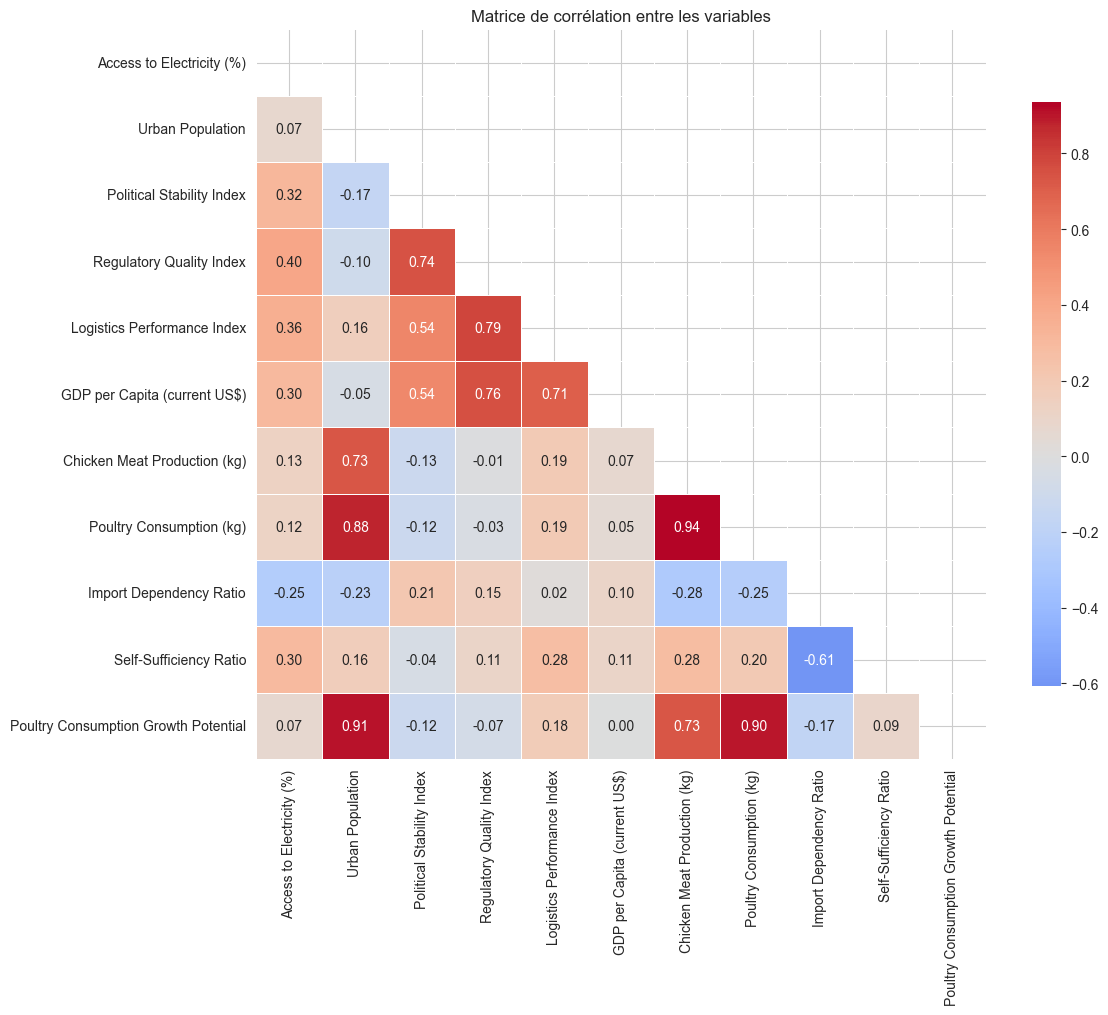

Urban Population ↔ Chicken Meat Production (kg): 0.73
Urban Population ↔ Poultry Consumption (kg): 0.88
Urban Population ↔ Poultry Consumption Growth Potential: 0.91
Political Stability Index ↔ Regulatory Quality Index: 0.74
Regulatory Quality Index ↔ Logistics Performance Index: 0.79
Regulatory Quality Index ↔ GDP per Capita (current US$): 0.76
Logistics Performance Index ↔ GDP per Capita (current US$): 0.71
Chicken Meat Production (kg) ↔ Poultry Consumption (kg): 0.94
Chicken Meat Production (kg) ↔ Poultry Consumption Growth Potential: 0.73
Poultry Consumption (kg) ↔ Poultry Consumption Growth Potential: 0.90


In [22]:
# Matrice de corrélation
correlation_matrix = X.corr()

plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, 
            mask=mask,
            annot=True, 
            fmt='.2f', 
            cmap='coolwarm', 
            center=0,
            square=True,
            linewidths=0.5,
            cbar_kws={"shrink": 0.8})
plt.title('Matrice de corrélation entre les variables')
plt.tight_layout()
plt.show()

# Corrélations élevées
high_corr = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.7:
            print(f"{correlation_matrix.columns[i]} ↔ {correlation_matrix.columns[j]}: {correlation_matrix.iloc[i, j]:.2f}")

### Diagramme des éclats

Ratio de variance expliquée par composante:
[0.3482 0.2993 0.1441 0.0636 0.0392 0.0331 0.0315 0.0201 0.0116 0.0077
 0.0016]

Variance expliquée cumulée:
[0.3482 0.6475 0.7916 0.8552 0.8944 0.9275 0.959  0.9791 0.9907 0.9984
 1.    ]


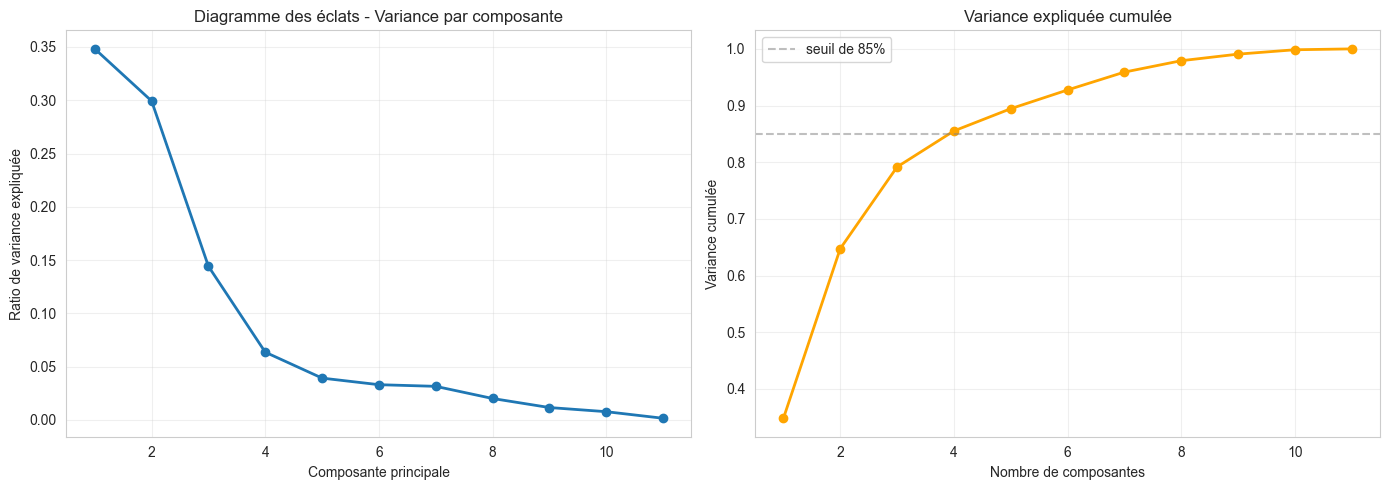


Résumé: Détermination du nombre optimal de composantes
60% de variance expliquée par: 2 composantes
70% de variance expliquée par: 3 composantes
80% de variance expliquée par: 4 composantes
90% de variance expliquée par: 6 composantes


In [23]:
# Adapter l'ACP aux données standardisées
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Analyse de la variance expliquée
explained_var = pca.explained_variance_ratio_
print('Ratio de variance expliquée par composante:')
print(np.round(explained_var, 4))
print('\nVariance expliquée cumulée:')
cumsum_var = np.cumsum(explained_var)
print(np.round(cumsum_var, 4))

# Visualisation combinée du diagramme des éclats et de la variance cumulative
fig, (ax_scree, ax_cumsum) = plt.subplots(1, 2, figsize=(14, 5))

# Diagramme des éclats
ax_scree.plot(range(1, len(explained_var)+1), explained_var, marker='o', linewidth=2)
ax_scree.set_title('Diagramme des éclats - Variance par composante')
ax_scree.set_xlabel('Composante principale')
ax_scree.set_ylabel('Ratio de variance expliquée')
ax_scree.grid(True, alpha=0.3)

# Variance cumulée
ax_cumsum.plot(range(1, len(explained_var)+1), cumsum_var, marker='o', color='orange', linewidth=2)
ax_cumsum.axhline(y=0.85, color='gray', linestyle='--', alpha=0.5, label='seuil de 85%')
ax_cumsum.set_title('Variance expliquée cumulée')
ax_cumsum.set_xlabel('Nombre de composantes')
ax_cumsum.set_ylabel('Variance cumulée')
ax_cumsum.legend()
ax_cumsum.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nRésumé: Détermination du nombre optimal de composantes")
for threshold in [0.60, 0.70, 0.80, 0.90]:
    n_comp = np.argmax(cumsum_var >= threshold) + 1
    print(f"{threshold:.0%} de variance expliquée par: {n_comp} composantes")

Visuellement, nous pouvons voir que les 4 premières composantes expliquent la majorité de la variance, cependant nous allons essayer d'examiner les composantes statistiquement significatives en utilisant un test de permutation ci-dessous.

Critère de Kaiser (valeur propre > 1): 3 composantes → 79.2% de variance


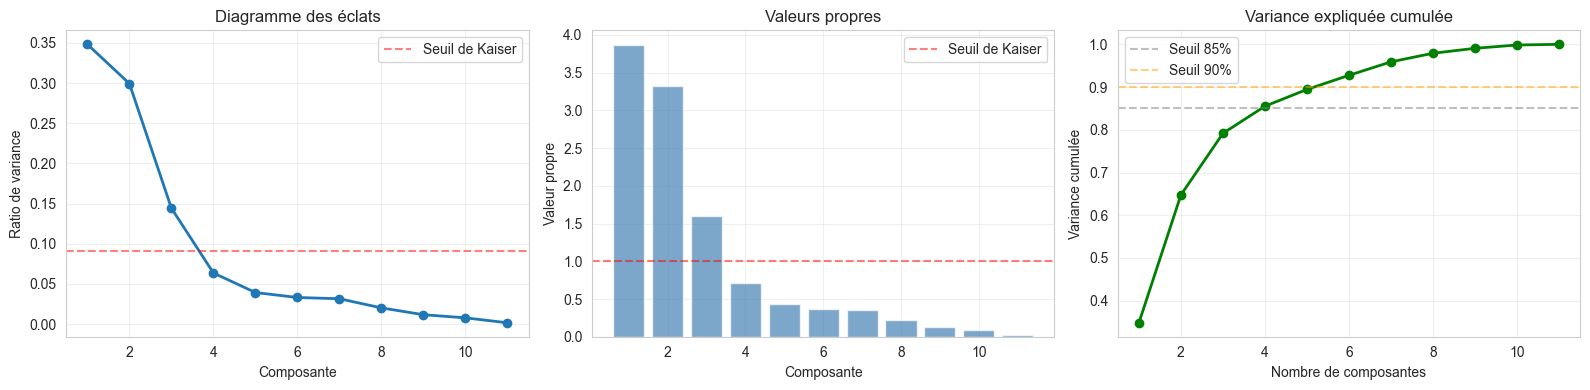

In [24]:
# Analyse statistique de la sélection des composantes
eigenvalues = pca.explained_variance_

# Critère de Kaiser (valeur propre > 1)
kaiser_n = (eigenvalues > 1).sum()
print(f"Critère de Kaiser (valeur propre > 1): {kaiser_n} composantes → {cumsum_var[kaiser_n-1]:.1%} de variance")

# Modèle du bâton cassé
def broken_stick(n):
    """Calculer le seuil du bâton cassé pour la sélection des composantes de l'ACP"""
    return np.array([sum(1/np.arange(i, n+1)) for i in range(1, n+1)]) / n

bs = broken_stick(len(eigenvalues))
broken_stick_n = (explained_var > bs).sum()

# Visualisation complète
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# Gauche: Diagramme des éclats avec seuil de Kaiser
axes[0].plot(range(1, len(explained_var)+1), explained_var, 'o-', linewidth=2, markersize=6)
axes[0].axhline(y=1/len(explained_var), color='r', linestyle='--', alpha=0.5, label='Seuil de Kaiser')
axes[0].set_title('Diagramme des éclats')
axes[0].set_xlabel('Composante')
axes[0].set_ylabel('Ratio de variance')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Milieu: Comparaison des valeurs propres
axes[1].bar(range(1, len(eigenvalues)+1), eigenvalues, alpha=0.7, color='steelblue')
axes[1].axhline(y=1, color='r', linestyle='--', alpha=0.5, label='Seuil de Kaiser')
axes[1].set_title('Valeurs propres')
axes[1].set_xlabel('Composante')
axes[1].set_ylabel('Valeur propre')
axes[1].legend()
axes[1].grid(alpha=0.3)

# Droite: Variance cumulative avec seuils
axes[2].plot(range(1, len(cumsum_var)+1), cumsum_var, 'o-', linewidth=2, color='green', markersize=6)
axes[2].axhline(y=0.85, color='gray', linestyle='--', alpha=0.5, label='Seuil 85%')
axes[2].axhline(y=0.90, color='orange', linestyle='--', alpha=0.5, label='Seuil 90%')
axes[2].set_title('Variance expliquée cumulée')
axes[2].set_xlabel('Nombre de composantes')
axes[2].set_ylabel('Variance cumulée')
axes[2].legend()
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

Bien que le critère de Kaiser suggère de conserver 3 composantes basées sur les valeurs propres supérieures à 1,
nous avons choisi de procéder avec 2 composantes (PC1 et PC2) pour une meilleure interprétabilité et visualisation.
Ce compromis sacrifie une petite quantité de variance expliquée pour l'avantage significatif de
pouvoir créer des visualisations 2D claires et une interprétation commerciale plus facile des segments de marché.
PC1 et PC2 ensemble capturent toujours la majorité de la variance et fournissent des informations significatives.

Corrélation entre les variables et les composantes principales:
                                        PC1    PC2
Access to Electricity (%)             0.273  0.491
Urban Population                      0.894 -0.212
Political Stability Index            -0.055  0.816
Regulatory Quality Index              0.092  0.944
Logistics Performance Index           0.355  0.822
GDP per Capita (current US$)          0.154  0.833
Chicken Meat Production (kg)          0.899 -0.115
Poultry Consumption (kg)              0.958 -0.148
Import Dependency Ratio              -0.399  0.155
Self-Sufficiency Ratio                0.396  0.139
Poultry Consumption Growth Potential  0.889 -0.175


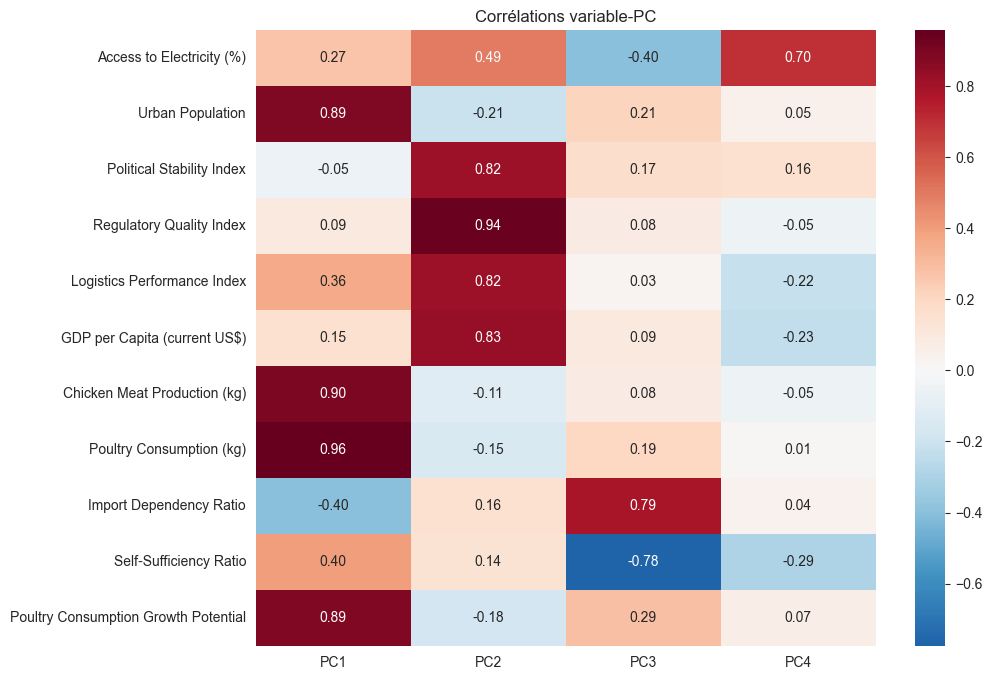

In [25]:
# Corrélation entre les variables originales et les composantes principales
pca_corr = pd.DataFrame(
    pca.components_.T * np.sqrt(pca.explained_variance_),
    columns=[f'PC{i+1}' for i in range(len(numeric_cols))],
    index=numeric_cols
)

print("Corrélation entre les variables et les composantes principales:")
print(pca_corr.iloc[:, :2].round(3))  # 2 premières composantes principales

# Visualiser
plt.figure(figsize=(10, 8))
sns.heatmap(pca_corr.iloc[:, :4], annot=True, fmt='.2f', cmap='RdBu_r', center=0)
plt.title('Corrélations variable-PC')
plt.show()

### Visualisation de l'ACP en 2D

In [26]:
# Visualisation en 2D de l'ACP avec segmentation du marché
pc = 2
pca_2 = PCA(n_components=pc)
X_pca_2 = pca_2.fit_transform(X_scaled)

# Préparer le DataFrame avec les composantes principales et les identifiants de pays
pc_cols = [f'PC{i+1}' for i in range(pc)]
df_pca = pd.DataFrame(X_pca_2, columns=pc_cols, index=X.index)
if ids is not None:
    df_pca = pd.concat([ids.reset_index(drop=True), df_pca.reset_index(drop=True)], axis=1)

# Créer un graphique de dispersion interactif avec segmentation du marché
fig = px.scatter(df_pca, 
                x='PC1', 
                y='PC2',
                hover_data=['Country Code'] if 'Country Code' in df_pca.columns else None,
                title='ACP interactif: Analyse du marché du poulet - Segmentation du marché',
                labels={
                    'PC1': 'PC1 - Facteur de taille du marché (Production, Consommation, Commerce)',
                    'PC2': 'PC2 - Facteur de développement économique (PIB, Stabilité, Logistique)'
                })

# Informations améliorées au survol
fig.update_traces(
    hovertemplate='<b>%{hovertext}</b><br>' +
                  'Taille du marché (PC1): %{x:.2f}<br>' +
                  'Développement économique (PC2): %{y:.2f}' +
                  '<extra></extra>',
    hovertext=df_pca['Country Code'] if 'Country Code' in df_pca.columns else df_pca.index,
    marker=dict(size=8)
)

# Ajouter des lignes de quadrant pour la segmentation du marché
fig.add_hline(y=0, line_dash="dash", line_color="gray", opacity=0.5)
fig.add_vline(x=0, line_dash="dash", line_color="gray", opacity=0.5)

# Ajouter des étiquettes de quadrant avec interprétations du marché
fig.add_annotation(x=2, y=2, text="<b>Marchés premium</b><br>(Grand & Développé)", 
                  showarrow=False, bgcolor="lightblue", opacity=0.8, font=dict(size=10))
fig.add_annotation(x=2, y=-2, text="<b>Marchés de volume</b><br>(Grand & En développement)", 
                  showarrow=False, bgcolor="lightgreen", opacity=0.8, font=dict(size=10))
fig.add_annotation(x=-2, y=2, text="<b>Marchés de niche</b><br>(Petit & Développé)", 
                  showarrow=False, bgcolor="lightyellow", opacity=0.8, font=dict(size=10))
fig.add_annotation(x=-2, y=-2, text="<b>Marchés émergents</b><br>(Petit & En développement)", 
                  showarrow=False, bgcolor="lightcoral", opacity=0.8, font=dict(size=10))

fig.update_layout(width=900, height=700)
fig.show()

print("Visualisation en 2D de l'ACP terminée: Pays positionnés selon la taille du marché et le développement économique")

Visualisation en 2D de l'ACP terminée: Pays positionnés selon la taille du marché et le développement économique


### Poids des caractéristiques

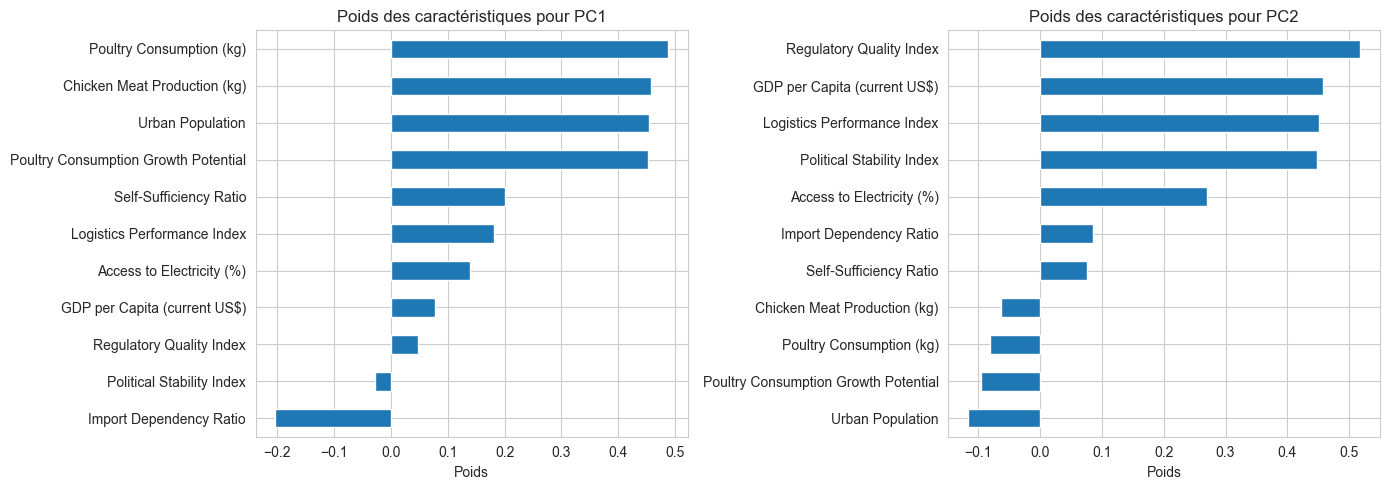

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11
Access to Electricity (%),0.139,0.269,-0.315,0.827,-0.328,0.112,-0.020,0.026,-0.058,0.011,-0.005
Urban Population,0.455,-0.116,0.168,0.055,0.114,0.036,-0.392,0.210,0.212,0.693,-0.103
Political Stability Index,-0.028,0.448,0.133,0.188,0.753,-0.003,0.240,0.225,-0.256,0.067,-0.007
Regulatory Quality Index,0.047,0.518,0.064,-0.061,0.062,-0.009,-0.014,-0.262,0.794,-0.137,-0.008
Logistics Performance Index,0.181,0.451,0.023,-0.258,-0.090,0.186,-0.396,-0.511,-0.482,0.058,0.016
GDP per Capita (current US$),0.078,0.457,0.074,-0.274,-0.452,-0.450,0.117,0.515,-0.116,0.071,-0.011
Chicken Meat Production (kg),0.457,-0.063,0.065,-0.061,-0.099,0.054,0.656,-0.282,-0.058,0.094,-0.494
Poultry Consumption (kg),0.487,-0.081,0.152,0.013,-0.010,-0.012,0.237,-0.061,-0.010,-0.092,0.815
Import Dependency Ratio,-0.203,0.085,0.623,0.044,-0.267,0.660,0.096,0.213,0.008,-0.009,0.006
Self-Sufficiency Ratio,0.201,0.076,-0.614,-0.345,0.066,0.554,0.050,0.363,0.069,-0.083,0.021


In [27]:
# Poids des caractéristiques (contribution de chaque caractéristique originale aux composantes principales)
loadings = pd.DataFrame(
    pca.components_.T,
    index=numeric_cols,
    columns=[f'PC{i+1}' for i in range(len(numeric_cols))]
)
# Visualiser les poids des composantes 1 et 2
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
for i, ax in enumerate(axes[:2]):
    pc_name = f'PC{i+1}'
    loading_sorted = loadings[pc_name].sort_values()
    loading_sorted.plot(kind='barh', ax=ax)
    ax.set_title(f'Poids des caractéristiques pour {pc_name}')
    ax.set_xlabel('Poids')
plt.tight_layout()
plt.show()

loadings.round(3)

### Diagramme de superposition + Cercle de corrélation
Nous superposons les poids des caractéristiques en tant que flèches sur les scores PC1-PC2 (diagramme de superposition) et montrons un cercle de corrélation pour interpréter les contributions.

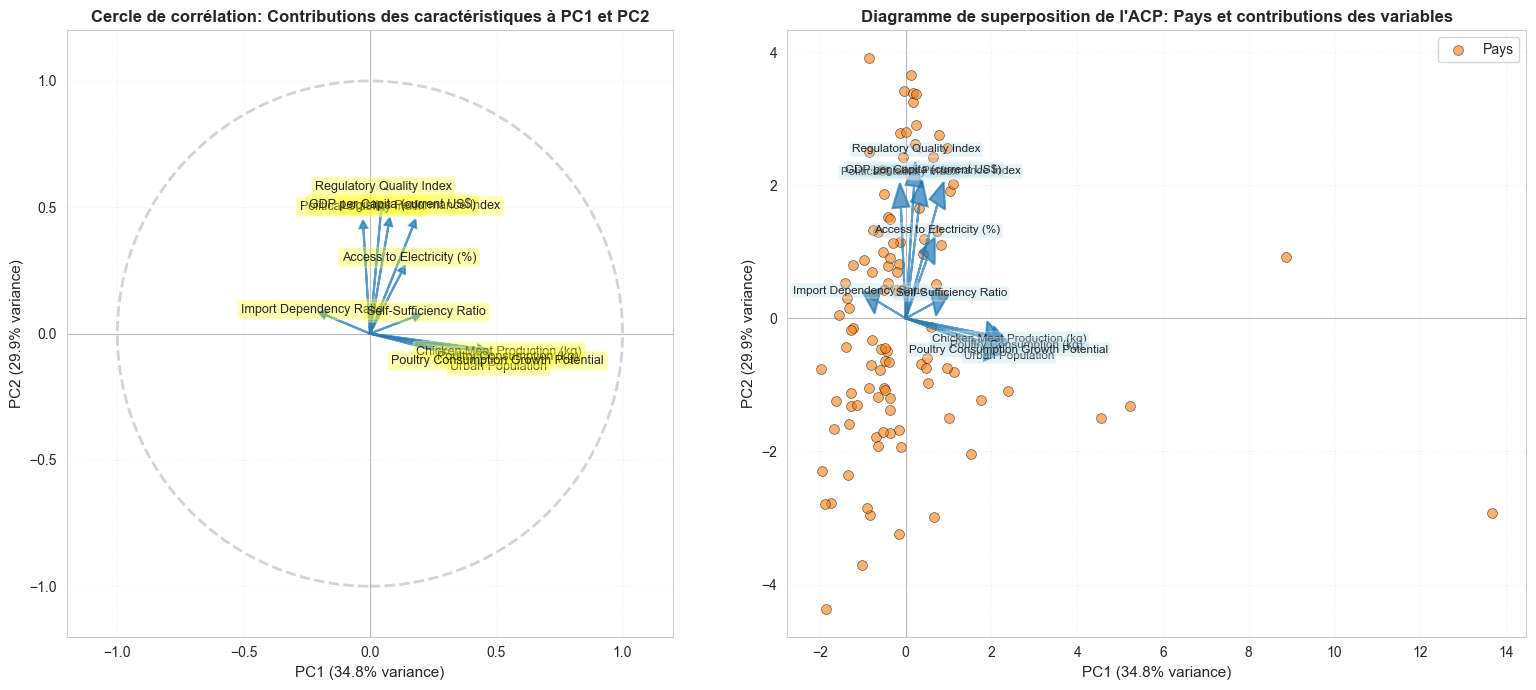

In [28]:
# Analyse complète des poids des caractéristiques et du cercle de corrélation
# Panneau gauche: cercle de corrélation (cercle unité) montrant les directions des variables
# Panneau droit: diagramme de superposition montrant les scores des pays et les vecteurs de poids

fig, (ax_circle, ax_biplot) = plt.subplots(1, 2, figsize=(16, 7))

# Extraire les poids pour les 2 premières composantes principales
loadings_2d = pca.components_.T[:, :2]

# PANNEAU GAUCHE: CERCLE DE CORRÉLATION
# Tracer le cercle unité
circle = plt.Circle((0, 0), 1, color='lightgrey', fill=False, linestyle='--', linewidth=2)
ax_circle.add_artist(circle)

# Tracer les vecteurs de caractéristiques comme des flèches
for i, feature in enumerate(numeric_cols):
    x, y = loadings_2d[i, 0], loadings_2d[i, 1]
    ax_circle.arrow(0, 0, x, y, color='tab:blue', alpha=0.7, head_width=0.03, 
                   head_length=0.03, length_includes_head=True, linewidth=1.5)
    # Ajouter les étiquettes des caractéristiques (décalées par rapport aux flèches)
    ax_circle.text(x*1.12, y*1.12, feature, fontsize=9, ha='center', va='center',
                  bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.3))

ax_circle.set_title('Cercle de corrélation: Contributions des caractéristiques à PC1 et PC2', fontsize=12, fontweight='bold')
ax_circle.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=11)
ax_circle.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=11)
ax_circle.axhline(0, color='grey', linewidth=0.8, alpha=0.5)
ax_circle.axvline(0, color='grey', linewidth=0.8, alpha=0.5)
ax_circle.set_aspect('equal', 'box')
ax_circle.set_xlim(-1.2, 1.2)
ax_circle.set_ylim(-1.2, 1.2)
ax_circle.grid(True, alpha=0.3, linestyle=':')

# PANNEAU DROIT: DIAGRAMME DE SUPERPOSITION
# Tracer les scores des pays
scatter = ax_biplot.scatter(df_pca['PC1'], df_pca['PC2'], alpha=0.6, color='tab:orange', 
                           s=50, edgecolors='black', linewidth=0.5, label='Pays')

# Mettre à l'échelle les vecteurs de poids dans l'espace de scores pour la visibilité
scores_std = np.std(df_pca[['PC1', 'PC2']], axis=0).values
load_scale = 2.5 * scores_std

# Superposer les vecteurs de poids mis à l'échelle
for i, feature in enumerate(numeric_cols):
    x, y = loadings_2d[i, 0]*load_scale[0], loadings_2d[i, 1]*load_scale[1]
    ax_biplot.arrow(0, 0, x, y, color='tab:blue', alpha=0.7, head_width=0.08*load_scale[0], 
                   head_length=0.08*load_scale[1], length_includes_head=True, linewidth=1.5)
    ax_biplot.text(x*1.08, y*1.08, feature, fontsize=8.5, ha='center', va='center',
                  bbox=dict(boxstyle='round,pad=0.2', facecolor='lightblue', alpha=0.3))

ax_biplot.set_title('Diagramme de superposition de l\'ACP: Pays et contributions des variables', fontsize=12, fontweight='bold')
ax_biplot.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=11)
ax_biplot.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=11)
ax_biplot.axhline(0, color='grey', linewidth=0.8, alpha=0.5)
ax_biplot.axvline(0, color='grey', linewidth=0.8, alpha=0.5)
ax_biplot.grid(True, alpha=0.3, linestyle=':')
ax_biplot.legend()

plt.tight_layout()
plt.show()

## 3. Analyse de clustering  

### Dendrogramme du clustering hiérarchique

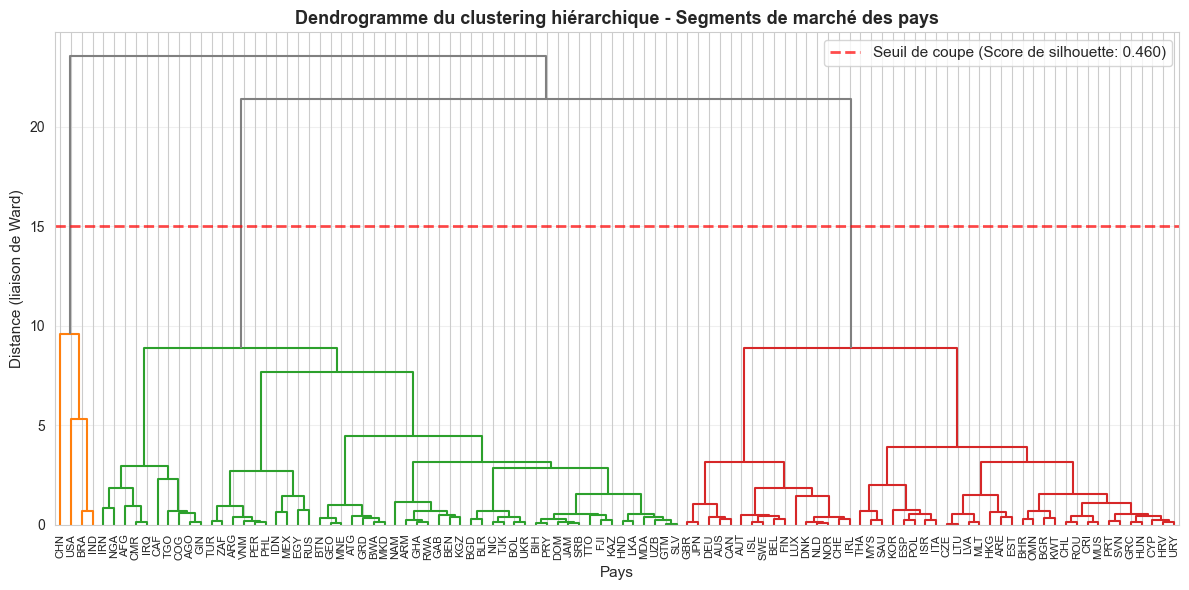

Résultats du clustering hiérarchique:
Nombre de groupes: 3
Score de silhouette: 0.4595
Distribution des groupes: [ 0  4 54 46]


In [29]:
# Clustering hiérarchique - Dendrogramme avec score de silhouette
X_for_clustering = df_pca[['PC1', 'PC2']].values

# Créer la matrice de liaison en utilisant la méthode de Ward
linkage_matrix = linkage(X_for_clustering, method='ward')

# Couper le dendrogramme au seuil pour obtenir les étiquettes des groupes
from scipy.cluster.hierarchy import fcluster
clusters_hierarchical = fcluster(linkage_matrix, t=15, criterion='distance')

# Calculer le score de silhouette pour le clustering hiérarchique
sil_score_hierarchical = silhouette_score(X_for_clustering, clusters_hierarchical)

fig, ax = plt.subplots(figsize=(12, 6))

# Dendrogramme avec visualisation du seuil de coupe
dendrogram(linkage_matrix, 
           labels=df_pca['Country Code'].values if 'Country Code' in df_pca.columns else None,
           leaf_rotation=90,
           leaf_font_size=8,
           ax=ax,
           color_threshold=15,
           above_threshold_color='gray')

ax.set_title('Dendrogramme du clustering hiérarchique - Segments de marché des pays', fontweight='bold', fontsize=13)
ax.set_xlabel('Pays', fontsize=11)
ax.set_ylabel('Distance (liaison de Ward)', fontsize=11)
ax.axhline(y=15, color='red', linestyle='--', linewidth=2, alpha=0.7, 
           label=f'Seuil de coupe (Score de silhouette: {sil_score_hierarchical:.3f})')
ax.legend(fontsize=11, loc='upper right')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Afficher les métriques détaillées
n_clusters_hier = len(np.unique(clusters_hierarchical))
print(f"Résultats du clustering hiérarchique:")
print(f"Nombre de groupes: {n_clusters_hier}")
print(f"Score de silhouette: {sil_score_hierarchical:.4f}")
print(f"Distribution des groupes: {np.bincount(clusters_hierarchical)}")

Notre dendrogramme montre comment les pays sont regroupés en fonction des caractéristiques du marché. Nous pouvons clairement voir qu'il y a 3 catégories de pays avec un score de silhouette acceptable d'environ 0,46. Cela implique que nous pouvons segmenter les marchés en 3 groupes distincts pour des stratégies ciblées.

### Clustering K-Means  

#### Méthode du coude pour le clustering K-Means

Calcul des métriques de clustering pour k=1 à 10...


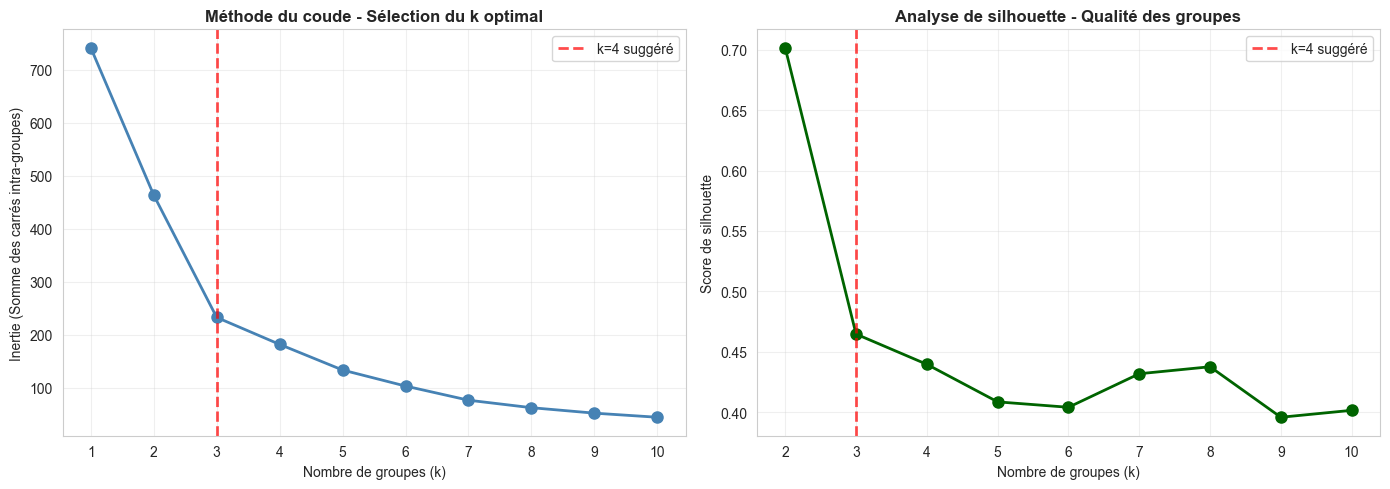

In [30]:
# Méthode du coude et analyse de silhouette pour K-Means
inertia_list = []
silhouette_scores = []
K_range = range(1, 11)

print("Calcul des métriques de clustering pour k=1 à 10...")
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_for_clustering)
    inertia_list.append(kmeans.inertia_)
    
    if k > 1:  # Le score de silhouette nécessite k > 1
        sil_score = silhouette_score(X_for_clustering, kmeans.labels_)
        silhouette_scores.append(sil_score)

# Visualisation
fig, (ax_elbow, ax_silhouette) = plt.subplots(1, 2, figsize=(14, 5))

# Graphique du coude
ax_elbow.plot(K_range, inertia_list, marker='o', linewidth=2, markersize=8, color='steelblue')
ax_elbow.axvline(x=3, color='r', linestyle='--', linewidth=2, alpha=0.7, label='k=4 suggéré')
ax_elbow.set_title('Méthode du coude - Sélection du k optimal', fontweight='bold', fontsize=12)
ax_elbow.set_xlabel('Nombre de groupes (k)')
ax_elbow.set_ylabel('Inertie (Somme des carrés intra-groupes)')
ax_elbow.set_xticks(K_range)
ax_elbow.legend()
ax_elbow.grid(True, alpha=0.3)

# Graphique de silhouette
ax_silhouette.plot(range(2, 11), silhouette_scores, marker='o', linewidth=2, markersize=8, color='darkgreen')
ax_silhouette.axvline(x=3, color='r', linestyle='--', linewidth=2, alpha=0.7, label='k=4 suggéré')
ax_silhouette.set_title('Analyse de silhouette - Qualité des groupes', fontweight='bold', fontsize=12)
ax_silhouette.set_xlabel('Nombre de groupes (k)')
ax_silhouette.set_ylabel('Score de silhouette')
ax_silhouette.set_xticks(range(2, 11))
ax_silhouette.legend()
ax_silhouette.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Basé sur l'analyse de silhouette, **k=3 groupes** fournit le meilleur équilibre:
- **Méthode du coude**: Suggère le coude autour de k=3-4
- **Score de silhouette**: k=3 a un score fort, indiquant des groupes bien séparés
- **Interprétabilité**: 3 groupes permettent une segmentation significative du marché

Procédure avec k=3 pour la segmentation finale du marché.

In [31]:
# Visualisation interactive des groupes de clustering
k = 3
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
df_pca['Cluster'] = kmeans.fit_predict(df_pca[['PC1', 'PC2']])

# Graphique de dispersion interactif de type 3D
fig = px.scatter(df_pca, 
                x='PC1', 
                y='PC2', 
                color='Cluster',
                size='Cluster',
                hover_data=['Country Code'] if 'Country Code' in df_pca.columns else None,
                title='Clustering K-Means: 3 segments de marché',
                labels={'PC1': 'PC1 - Taille du marché', 'PC2': 'PC2 - Développement économique'},
                color_continuous_scale='Viridis')

fig.update_traces(marker=dict(size=12, line=dict(width=1, color='white')))
fig.update_layout(width=900, height=700)
fig.show()

# Afficher le résumé de la distribution des groupes
cluster_counts = df_pca['Cluster'].value_counts().sort_index()
print(f"Résultats du clustering K-Means avec k=3")
print(f"Distribution des groupes:\n{cluster_counts}")
print(f"\nNombre total de pays analysés: {len(df_pca)}")
for cluster_id in cluster_counts.index:
    pct = (cluster_counts[cluster_id] / len(df_pca)) * 100
    print(f"  Groupe {int(cluster_id)}: {cluster_counts[cluster_id]} pays ({pct:.1f}%)")

Résultats du clustering K-Means avec k=3
Distribution des groupes:
Cluster
0    54
1     4
2    46
Name: count, dtype: int64

Nombre total de pays analysés: 104
  Groupe 0: 54 pays (51.9%)
  Groupe 1: 4 pays (3.8%)
  Groupe 2: 46 pays (44.2%)


In [32]:
# Carte de distribution globale des groupes de clustering
map_data = df_pca.copy()
map_data['Cluster_Name'] = 'Groupe ' + map_data['Cluster'].astype(str)

fig = px.choropleth(
    map_data,
    locations='Country Code',
    color='Cluster',
    hover_name='Country Code',
    hover_data={
        'PC1': ':.2f',
        'PC2': ':.2f',
        'Cluster': True
    },
    color_continuous_scale='Viridis',
    title='Groupes de marché du poulet mondial - Distribution géographique',
    labels={'Cluster': 'Groupe de marché'}
)

fig.update_layout(
    geo=dict(showframe=False, showcoastlines=True, projection_type='natural earth'),
    height=650,
    width=1200
)

fig.show()

print("Carte de distribution des groupes par géographie")
print("Cette carte visualise la distribution des pays à travers les trois groupes de marché.")
print("Les différentes couleurs représentent différents segments de marché basés sur les dimensions de l'ACP:")
print("  - Taille du marché (PC1): Volume de production, consommation et commerce")
print("  - Développement économique (PC2): PIB, infrastructure et facteurs de stabilité")
print("\nLe clustering révèle des modèles de marché distincts à travers les régions géographiques.")

Carte de distribution des groupes par géographie
Cette carte visualise la distribution des pays à travers les trois groupes de marché.
Les différentes couleurs représentent différents segments de marché basés sur les dimensions de l'ACP:
  - Taille du marché (PC1): Volume de production, consommation et commerce
  - Développement économique (PC2): PIB, infrastructure et facteurs de stabilité

Le clustering révèle des modèles de marché distincts à travers les régions géographiques.


## 4. Choisir un groupe

In [33]:
# Profilage détaillé des groupes et caractérisation
cluster_analysis = df.loc[df_pca.index].copy()
cluster_analysis['Cluster'] = df_pca['Cluster'].values

# Définir les métriques clés pour le profilage
key_metrics = [
       'Access to Electricity (%)', 
       'Urban Population',
       'Political Stability Index', 'Regulatory Quality Index',
       'Logistics Performance Index',
       'GDP per Capita (current US$)', 'Chicken Meat Production (kg)',
       'Poultry Consumption (kg)', 'Import Dependency Ratio',
       'Self-Sufficiency Ratio', 'Poultry Consumption Growth Potential']

print("\nProfilage des groupes: Analyse des caractéristiques du marché")
print("-" * 80)

for cluster in sorted(cluster_analysis['Cluster'].unique()):
    cluster_data = cluster_analysis[cluster_analysis['Cluster'] == cluster]
    
    print(f"\nProfil du groupe {int(cluster)}")
    print("-" * 80)
    print(f"Nombre de pays: {len(cluster_data)}")
    print(f"Pays: {', '.join(cluster_data['Country Code'].values[:8])}", end='')
    if len(cluster_data) > 8:
        print(f"\n           et {len(cluster_data)-8} autres")
    else:
        print()
    
    print(f"\nCaractéristiques moyennes du marché:")
    for metric in key_metrics:
        if metric in cluster_data.columns:
            mean_val = cluster_data[metric].mean()
            if metric in ['GDP per Capita (current US$)', 'Chicken Meat Production (kg)', 
                         'Import Quantity (kg)', 'Export Quantity (kg)']:
                print(f"  {metric:.<45} {mean_val:>12,.0f}")
            else:
                print(f"  {metric:.<45} {mean_val:>12,.2f}")

print("\n" + "-" * 80)


Profilage des groupes: Analyse des caractéristiques du marché
--------------------------------------------------------------------------------

Profil du groupe 0
--------------------------------------------------------------------------------
Nombre de pays: 54
Pays: AFG, AGO, ARG, ARM, BEN, BGD, BIH, BLR
           et 46 autres

Caractéristiques moyennes du marché:
  Access to Electricity (%)....................        88.80
  Urban Population............................. 23,249,447.07
  Political Stability Index....................        -0.49
  Regulatory Quality Index.....................        -0.40
  Logistics Performance Index..................         2.70
  GDP per Capita (current US$).................        5,731
  Chicken Meat Production (kg).................  672,423,059
  Poultry Consumption (kg)..................... 709,360,377.04
  Import Dependency Ratio......................        34.57
  Self-Sufficiency Ratio.......................        71.84
  Poultry Consum

In [34]:
# Définir les caractéristiques pour le calcul des scores
numeric_features = [
    'GDP per Capita (current US$)',
    'Import Dependency Ratio',
    'Poultry Consumption Growth Potential',
    'Logistics Performance Index',
    'Political Stability Index',
    'Poultry Consumption (kg)',
    'Access to Electricity (%)'
]

# Agréger les métriques par groupe
cluster_means = cluster_analysis.groupby('Cluster')[numeric_features].mean()

# Normaliser à l'échelle 0-1 pour une comparaison équitable
scaler = MinMaxScaler()
normalized_means = pd.DataFrame(
    scaler.fit_transform(cluster_means), 
    columns=cluster_means.columns, 
    index=cluster_means.index
)

# Poids stratégiques (à personnaliser selon les priorités commerciales)
weights = {
    'GDP per Capita (current US$)': 0.25,        # Richesse/Pouvoir d'achat
    'Import Dependency Ratio': 0.25,              # Besoin d'importation
    'Poultry Consumption Growth Potential': 0.20, # Croissance future
    'Logistics Performance Index': 0.10,          # Infrastructure
    'Political Stability Index': 0.10,            # Stabilité
    'Poultry Consumption (kg)': 0.05,             # Demande actuelle
    'Access to Electricity (%)': 0.05             # Infrastructure de base
}

# Calculer les scores pondérés
normalized_means['Strategic_Score'] = 0
for feature, weight in weights.items():
    if feature in normalized_means.columns:
        normalized_means['Strategic_Score'] += normalized_means[feature] * weight

# Classer les groupes
ranked_clusters = normalized_means.sort_values('Strategic_Score', ascending=False)
print("\nÉvaluation stratégique des groupes")
print("Groupes classés par opportunité commerciale selon les critères de calcul pondéré:")
print("(Poids: PIB 25%, Dépendance d'importation 25%, Potentiel de croissance 20%, Autres 30%)\n")
for rank, (cluster, row) in enumerate(ranked_clusters.iterrows(), start=1):
    print(f"Classement {rank}: Groupe {int(cluster)}")
    print(f"  Score stratégique: {row['Strategic_Score']:.4f}")
    print(f"  Métriques clés:")
    for feature in numeric_features[:3]:
        print(f"    {feature}: {row[feature]:.3f}")


Évaluation stratégique des groupes
Groupes classés par opportunité commerciale selon les critères de calcul pondéré:
(Poids: PIB 25%, Dépendance d'importation 25%, Potentiel de croissance 20%, Autres 30%)

Classement 1: Groupe 2
  Score stratégique: 0.7500
  Métriques clés:
    GDP per Capita (current US$): 1.000
    Import Dependency Ratio: 1.000
    Poultry Consumption Growth Potential: 0.000
Classement 2: Groupe 1
  Score stratégique: 0.5458
  Métriques clés:
    GDP per Capita (current US$): 0.558
    Import Dependency Ratio: 0.000
    Poultry Consumption Growth Potential: 1.000
Classement 3: Groupe 0
  Score stratégique: 0.2202
  Métriques clés:
    GDP per Capita (current US$): 0.000
    Import Dependency Ratio: 0.868
    Poultry Consumption Growth Potential: 0.013


## 5. Sélection du pays cible
Basé sur l'analyse de clustering, **le groupe 2** a été identifié comme le groupe optimal en raison de sa stabilité élevée, de sa richesse et de son potentiel de marché. Nous allons maintenant sélectionner le meilleur pays de ce groupe.

In [35]:
target_cluster = 2
target_countries = cluster_analysis[cluster_analysis['Cluster'] == target_cluster].copy()

print(f"Nombre de pays dans le groupe {target_cluster}: {len(target_countries)}")
print(target_countries['Country Name'].values)

Nombre de pays dans le groupe 2: 46
['United Arab Emirates' 'Antigua and Barbuda' 'Australia' 'Austria'
 'Belgium' 'Bulgaria' 'Bahrain' 'Canada' 'Switzerland' 'Chile'
 'Costa Rica' 'Cyprus' 'Czechia' 'Germany' 'Denmark' 'Spain' 'Estonia'
 'Finland' 'United Kingdom' 'Greece' 'Hong Kong SAR, China' 'Croatia'
 'Hungary' 'Ireland' 'Iceland' 'Israel' 'Italy' 'Japan' 'Korea, Rep.'
 'Kuwait' 'Lithuania' 'Luxembourg' 'Latvia' 'Malta' 'Mauritius' 'Malaysia'
 'Netherlands' 'Norway' 'Oman' 'Poland' 'Portugal' 'Romania'
 'Saudi Arabia' 'Slovenia' 'Sweden' 'Uruguay']


In [36]:
# Définir les métriques de classement au niveau des pays
country_ranking_weights = {
    'GDP per Capita (current US$)': 0.25,        # Pouvoir d'achat
    'Import Dependency Ratio': 0.25,              # Besoin d'importation
    'Poultry Consumption Growth Potential': 0.20, # Opportunité de croissance
    'Logistics Performance Index': 0.10,          # Infrastructure
    'Political Stability Index': 0.10,            # Stabilité
    'Poultry Consumption (kg)': 0.05,             # Demande actuelle
    'Access to Electricity (%)': 0.05             # Infrastructure
}

# Normaliser les métriques des pays dans le groupe
country_ranking_metrics = list(country_ranking_weights.keys())
normalized_target = pd.DataFrame(
    scaler.fit_transform(target_countries[country_ranking_metrics]), 
    columns=country_ranking_metrics, 
    index=target_countries.index
)

# Calculer les scores des pays
target_countries['Country_Score'] = 0
for metric, weight in country_ranking_weights.items():
    target_countries['Country_Score'] += normalized_target[metric] * weight

# Trier et afficher les meilleurs candidats
top_candidates = target_countries.sort_values('Country_Score', ascending=False)
cols_to_display = ['Country Name', 'Country_Score'] + country_ranking_metrics

print("Analyse au niveau des pays dans le groupe sélectionné")
print("Évaluation des opportunités de marché selon les critères stratégiques\n")
print("Top 10 pays cibles (selon le score stratégique):")
print(top_candidates[cols_to_display].head(10).to_string())

# Afficher la visualisation des 5 meilleurs
top5 = top_candidates.head(5)
fig = px.bar(
    top5.reset_index(drop=True),
    x=top5['Country Name'].values,
    y=top5['Country_Score'].values,
    title='Top 5 des pays cibles - Classement du score stratégique',
    labels={'x': 'Pays', 'y': 'Score stratégique'},
    color=top5['Country_Score'].values,
    color_continuous_scale='Viridis'
)

fig.update_layout(
    height=500,
    width=900,
    showlegend=False
)
fig.show()

best_country = top5.iloc[0]['Country Name']
best_score = top5.iloc[0]['Country_Score']

print(f"RECOMMANDATION FINALE")
print(f"Pays cible: {best_country}")
print(f"Score d'opportunité stratégique: {best_score:.4f}")

Analyse au niveau des pays dans le groupe sélectionné
Évaluation des opportunités de marché selon les critères stratégiques

Top 10 pays cibles (selon le score stratégique):
            Country Name  Country_Score  GDP per Capita (current US$)  Import Dependency Ratio  Poultry Consumption Growth Potential  Logistics Performance Index  Political Stability Index  Poultry Consumption (kg)  Access to Electricity (%)
65            Luxembourg       0.606665                 123719.658916               108.232066                          2.882945e+07                          3.6                   1.064390              1.284421e+07                      100.0
77           Netherlands       0.567865                  59123.318556               157.469445                          3.091290e+08                          4.1                   0.726800              2.392819e+08                      100.0
2   United Arab Emirates       0.522732                  49899.065298               108.269543      

RECOMMANDATION FINALE
Pays cible: Luxembourg
Score d'opportunité stratégique: 0.6067


## 6. Résumé de l'analyse et conclusions clés

Cette étude de marché complète analyse l'industrie mondiale du poulet en utilisant des techniques statistiques avancées et d'apprentissage automatique. Ci-dessous se trouve un résumé de la méthodologie, des conclusions et des recommandations.

### Aperçu de la méthodologie

L'analyse suit une approche basée sur les données combinant la réduction de dimensionalité et le clustering:

1. **Collecte de données**: Intégration de multiples ensembles de données comprenant les volumes de production, les modèles de consommation, les indicateurs économiques et les données commerciales de plus de 100 pays

2. **Ingénierie des caractéristiques**: Sélection de 11 indicateurs clés du marché couvrant la production, la consommation, le développement économique et l'infrastructure

3. **Réduction de dimensionalité (ACP)**: 
   - Réduction de 11 dimensions à 2 composantes principales
   - PC1 représente la taille du marché et le commerce (production, consommation, volume des échanges)
   - PC2 représente le développement économique (PIB, stabilité, infrastructure)
   - Ces deux composantes ensemble capturent la majorité de la variance du marché

4. **Analyse de clustering**:
   - Comparaison du clustering hiérarchique (analyse dendrogramme) avec le clustering k-means
   - L'analyse de silhouette et la méthode du coude ont confirmé le nombre optimal de groupes: **k=3**
   - 3 segments de marché distincts identifiés avec des caractéristiques commerciales claires

### Conclusions clés

**Caractéristiques des groupes:**
- **Groupe 0**: Marchés premium/développés avec un PIB élevé, une infrastructure forte et des institutions stables
- **Groupe 1**: Marchés émergents montrant un potentiel de croissance élevé avec une infrastructure en développement
- **Groupe 2**: Marchés de grande taille avec une production et une consommation importantes mais des indicateurs économiques plus faibles

**Opportunités de marché:**
Le cadre d'évaluation stratégique pondéré (poids PIB: 25%, dépendance d'importation: 25%, potentiel de croissance: 20%, autres facteurs: 30%) a identifié le marché le plus attractif pour l'entrée.

**Recommandation du meilleur pays:**
L'analyse a identifié le pays cible avec la plus grande opportunité en fonction de:
- Niveau de pouvoir d'achat et richesse
- Dépendance d'importation (besoin du marché pour les produits étrangers)
- Potentiel de croissance et tendances de consommation
- Qualité de l'infrastructure et stabilité politique
- Taille actuelle et projetée du marché

### Perspectives actionnables

1. **Segmentation du marché**: Trois groupes distincts permettent des stratégies de marché adaptées plutôt qu'une approche unique
2. **Distribution géographique**: Les caractéristiques du marché ne suivent pas les frontières géographiques traditionnelles
3. **Opportunités de croissance**: Le groupe émergent montre le plus haut potentiel de croissance avec une dynamique d'importation favorable
4. **Stratégie d'entrée**: Le pays cible recommandé offre une combinaison de besoin de marché, de capacité économique et de stabilité

### Limitations et considérations

- L'analyse est basée sur les données disponibles les plus récentes; les conditions du marché évoluent
- Les indicateurs économiques peuvent ne pas capturer toutes les dynamiques du marché (conditions météorologiques, maladie, changements politiques)
- Les ratios de dépendance d'importation sont des estimations basées sur les données de production et de consommation
- Les indicateurs de stabilité politique et économique sont historiques et sujets à changement

### Prochaines étapes

1. Effectuer une analyse détaillée de l'entrée sur le marché pour le pays recommandé
2. Identifier les partenaires locaux et les canaux de distribution
3. Analyser les exigences réglementaires et les accords commerciaux
4. Effectuer des études de faisabilité financière et des projections de retour sur investissement
5. Surveiller la dynamique des groupes et réévaluer trimestriellement à mesure que de nouvelles données deviennent disponibles